# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

### 1. Imports

Implementations of LSTM and GRU classifiers, the main extraction method, and our own implenetations of DFACrawler, swapTracker, swapSuggester, FreqAnalysis, and rotationChecker

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract

#from ALGO_CODE.database import meaningfulWords, meaninglessWords
#from ALGO_CODE.swapController import swapTracker, swapSuggester
#from ALGO_CODE.decypherTools import DFACrawler, FreqAnalysis, rotationChecker

### 2. Training

#### 2.1. Define a Language
Here we provide examples of meaningful english words, and meaningless english words

In [2]:
#MEANINGFUL_WORDS = meaningfulWords.getAllWords()
#MEANINGLESS_WORDS = meaninglessWords.getAllWords()
#def target(w):             
#   if w.lower() in MEANINGFUL_WORDS:
#      return True
#   else:
#      return False
#alphabet = "etaoins" ##The RNN and DFA use this

In [3]:
#print(target("IS"))
#print(target("EAT"))
#print(target("TINS"))
#print(target('NOT'))

True
False
True
False


#### 2.2. Create a Train Set

train_set is automatically filled out with meaningfully words, meaningless words, and their classificatation values

In [4]:
#meaningfullClass = [(word, True) for word in MEANINGFUL_WORDS]
#meaninglessClass = [(word, True) for word in MEANINGLESS_WORDS]
#train_set = meaningfullClass + meaninglessClass

made train set of size: 488 , of which positive examples: 219


In [5]:
print(len(train_set))
print(list(train_set.items())[:10])

488
[('c', True), ('g', True), ('b', True), ('j', True), ('h', True), ('e', True), ('f', True), ('d', True), ('a', True), ('i', True)]


#### 2.3. Create and Train a Network


`RNNClassifier` generates an RNN-Classifier for a given alphabet.
Its optional parameters are:
>1. `num_layers` (default value 2): the number of hidden layers
>2. `hidden_dim` (default value 5): the size of the hidden layers
>3. `input_dim` (default value 3): the size of the input vectors (these networks use embedding, not one-hot encoding)
>4. `RNNClass` (default value `LSTMNetwork`): the RNN architecture (possible values `LSTMNetwork`, `GRUNetwork`)

In [6]:
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


The function `mixed_curriculum_train(rnn,train_set)` trains the network `rnn` with the given dictionary of labeled examples, `train_set`. Its optional parameters are: 
>1. `stop_threshold` (default $0.001$): the threshold for the average loss of the network on the train set under which training is cut short
>2. `learning_rate` (defualt 0.001): learning rate for optimiser
>2. `length_epochs` (default $5$): explained below
>3. `random_batch_epochs` (default $100$): below
>4. `random_batch_size` (default $20$): below
>5. `single_batch_epochs` (default $100$): below
>6. `outer_loops` (default $3$): below

`mixed_curriculum_train` splits the input dictionary first into batches by length, training for `length_epochs` iterations each of these batches, by order of increasing length. Then for `random_batch_epochs` iterations it will, at each iteration, split the dictionary into random batches of size `random_batch_size` and train each batch for one iteration. After that it will train the dictionary as one big batch for `single_batch_epochs` iterations. It does all of this `outer_loops` times.

This will print some scatter plots of the average loss on the train set. The plots will come in pairs: each time one for the most recent iterations of training where the whole dictionary was trained as one batch, and another for all the iterations the rnn has been trained since its initialisation.

`mixed_curriculum_train` should work for most simple targets without any tinkering. If the network doesn't drop under the stop threshold, you may want to call it again.

current average loss is:  0.6846266479492188
current average loss is:  0.5687826528549195
current average loss is:  0.44556875777244564
current average loss is:  0.40409493160247806
current average loss is:  0.3691773087978363


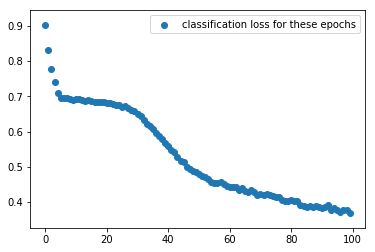

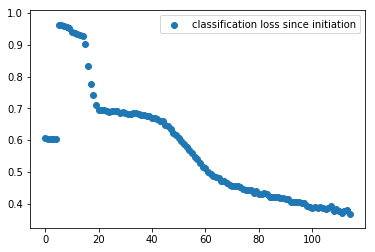

current average loss is:  0.3610263574318808
current average loss is:  0.3521937698614402
current average loss is:  0.3430101050705206
current average loss is:  0.333404791159708
current average loss is:  0.3232459083932345


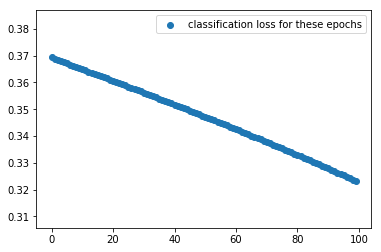

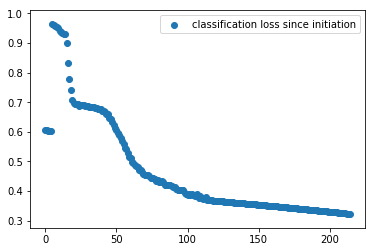

current average loss is:  0.2853749747276307
current average loss is:  0.24905594003200526
current average loss is:  0.22813179826736452
current average loss is:  0.20803145408630372
current average loss is:  0.17940625071525573


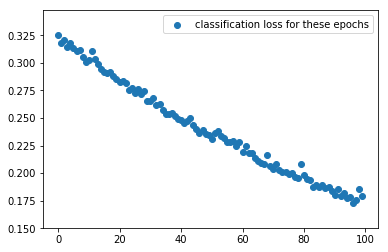

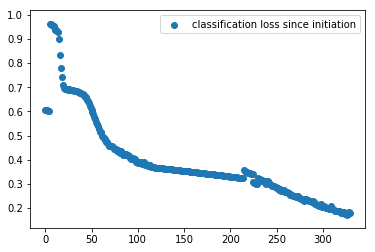

current average loss is:  0.16037254646176197
current average loss is:  0.15090431150842887
current average loss is:  0.14125334630247022
current average loss is:  0.13177390176741804
current average loss is:  0.12236670197033492


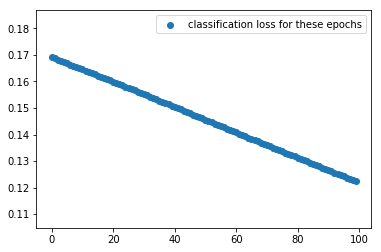

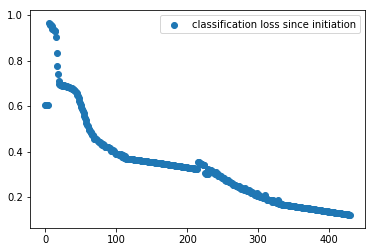

current average loss is:  0.10172484695911407
current average loss is:  0.0870944796204567
current average loss is:  0.08203500205278398
current average loss is:  0.061831841304898265
current average loss is:  0.052361342102289196


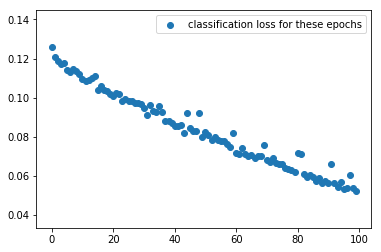

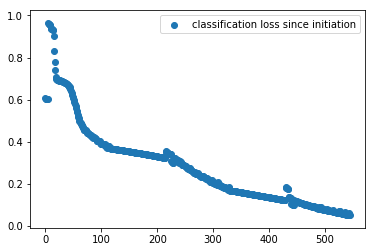

current average loss is:  0.04431117558088459
current average loss is:  0.04013496539631828
current average loss is:  0.03620851626161669
current average loss is:  0.03255651427097008
current average loss is:  0.02915883650545214


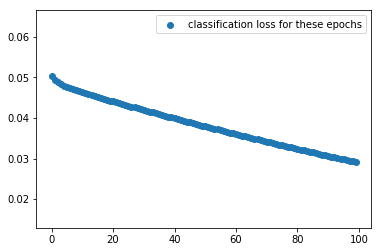

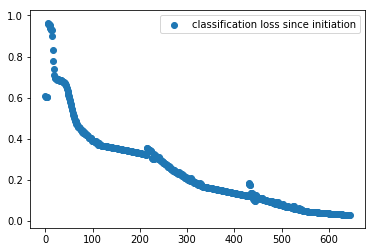

classification loss on last batch was: 0.02915883650545214


In [7]:
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)

### 3. Extraction

#### 3.1. Initial Examples

In Section 7.3 of the paper we note that the process sometimes needs one positive and one negative initial sample to get started. We take these from the training set, using the shortest sample from each class.

If extracting from a network you no longer have the train set for, you can also make such a list manually. 
Of course, there is nothing to stop you from having more than one initial sample from each class, or not using any, and so on.

In [8]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)

['c', 'hi']


#### 3.2. Clear the Computation Graph
If you're using our network classes, and just running one network at a time, you don't need this. Still, it's good practice. `renew` function resets the DyNet computation graph and refreshes the calling network's initial vectors.

In [9]:
rnn.renew()

#### 3.3. Extract
It is generally necessary to give the extraction some `starting_examples` to work with, so it doesn't get stuck on a single state automaton (Section 7.3. in the paper). We made those in Section 3.1. of this notebook.

You can set a `time_limit` on the extraction (default $50$ seconds) and the `initial_split_depth` (default $10$) for the initial aggressive refinement (which is described in Section 7.3.1. of our extraction paper).


During extraction, the method will report the counterexamples it finds, how long it took to find each one, and how long it took to refine the observation table (i.e. how long it took to update the $L^*$ automaton) between each two equivalence queries. Every time it starts a new equivalence query, if the proposed DFA has less than $30$ states, it will also display it.

provided counterexamples are: ['c', 'hi']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 2


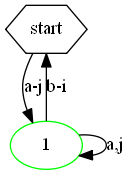

['', 'a']
refining, H size is 1
split wasn't perfect: gotta start over
['e', 'f']
['a', 'j']
['aa', 'ab']
refining, H size is 1
['ad', 'ae']
['ac', 'af']
['aa', 'ag']
refining, H size is 1
['ag', 'ah']
returning counterexample of length 2:		ba, this counterexample is rejected by the given RNN.
equivalence checking took: 0.09164401599991834
obs table refinement took 0.024
guided starting equivalence query for DFA of size 7


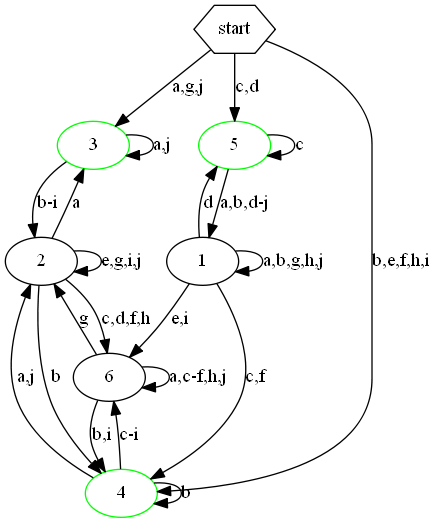

['e', 'f']
['a', 'j']
['ad', 'ae']
['ac', 'af']
['ag', 'ah']
['b', 'bb']
['bc', 'bd']
['bc', 'bd', 'be']
['bc', 'bd', 'be', 'bf']
['ba', 'bg']
refining, H size is 1
['bg', 'bh']
['b', 'bb', 'bi']
refining, H size is 2
['d', 'ca']
refining, H size is 1
['ce', 'cf']
['bg', 'bh', 'cg']
refining, H size is 2
['ce', 'cf', 'ch']
['ce', 'cf', 'ch', 'ci']
['ca', 'cj']
['ca', 'cj', 'da']
['c', 'dd']
returning counterexample of length 2:		dd, this counterexample is accepted by the given RNN.
equivalence checking took: 0.0774337400002878
obs table refinement took 0.112
guided starting equivalence query for DFA of size 19


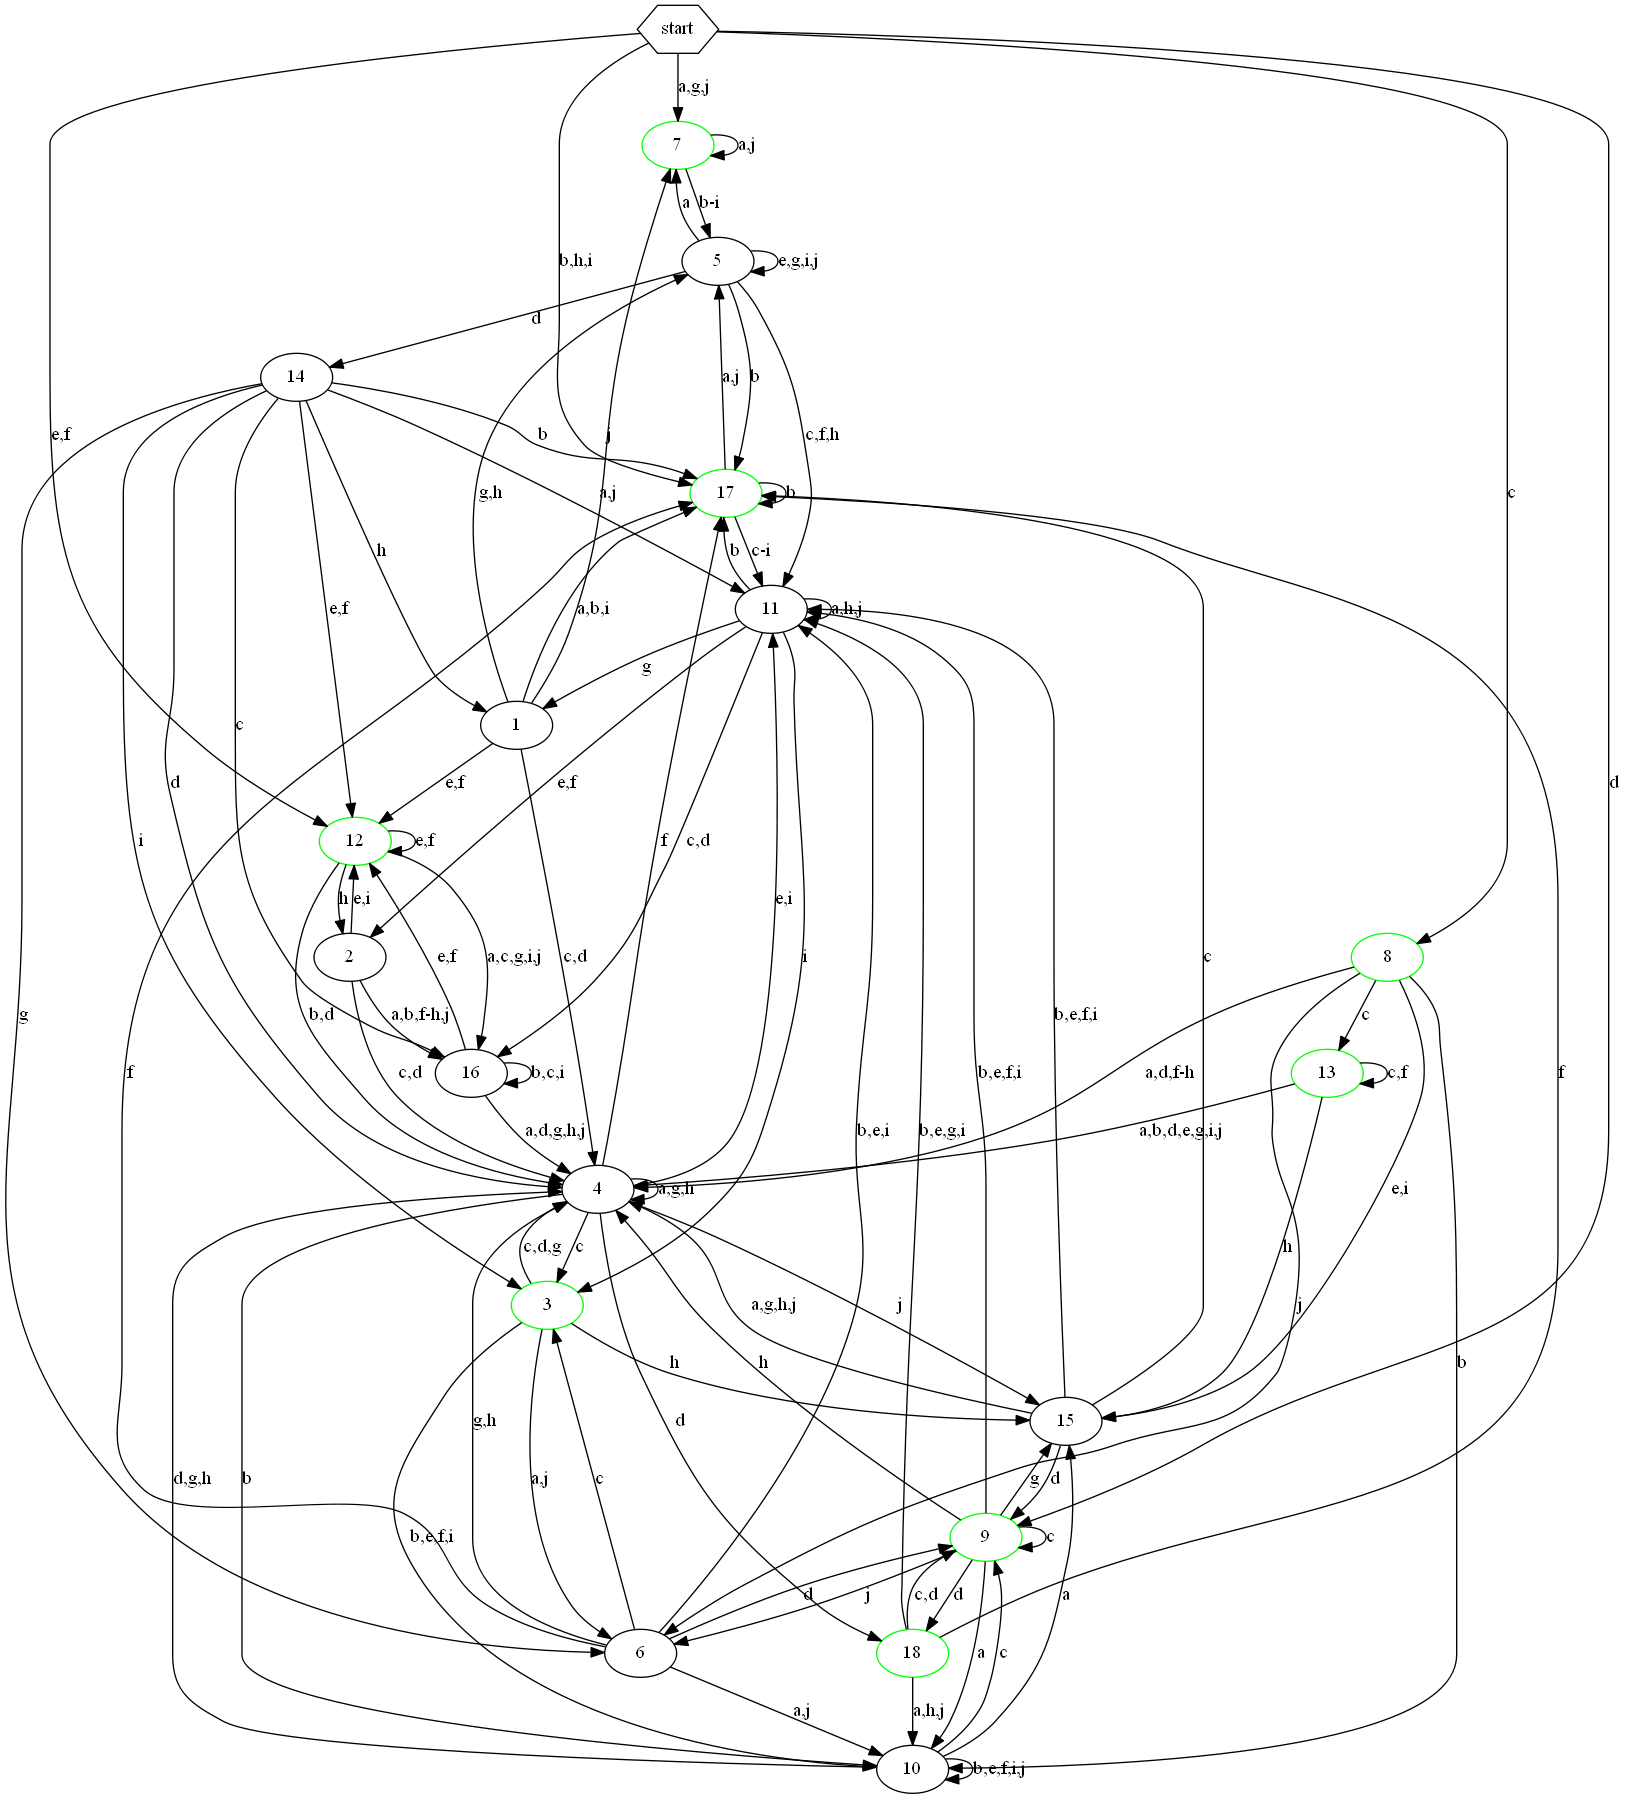

['e', 'f']
['a', 'j']
['ad', 'ae']
['ac', 'af']
['ag', 'ah']
['b', 'bb']
['bc', 'bd']
['bc', 'bd', 'be']
['bc', 'bd', 'be', 'bf']
['bg', 'bh']
['ce', 'cf']
refining, H size is 1
['ce', 'ch']
refining, H size is 1
['ce', 'ci']
['ca', 'cj']
refining, H size is 1
['cj', 'da']
refining, H size is 1
['c', 'dd']
refining, H size is 1
['ca', 'de']
returning counterexample of length 3:		deb, this counterexample is rejected by the given RNN.
equivalence checking took: 0.31279290200018295
obs table refinement took 0.568
guided starting equivalence query for DFA of size 53
['e', 'f']
['a', 'j']
['ad', 'ae']
['ac', 'af']
['ag', 'ah']
returning counterexample of length 3:		agj, this counterexample is accepted by the given RNN.
equivalence checking took: 0.00640075599994816
obs table refinement took 1.082
guided starting equivalence query for DFA of size 76
['e', 'f']
['a', 'j']
returning counterexample of length 3:		jfj, this counterexample is accepted by the given RNN.
equivalence checking took: 0

In [10]:
dfa = extract(rnn,time_limit = 50,initial_split_depth = 10,starting_examples=starting_examples)

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [11]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

testing on train set, i.e. test set is train set
test set size: 488
of which positive: 219 (44.87%)
rnn score against target on test set: 487 (99.79%)
extracted dfa score against rnn on test set: 398 (81.55%)
extracted dfa score against target on rnn's test set: 397 (81.35%)
